# Steps
1- Realease the particles (2_PT_seseflux)

2- Read the particles for each month 

3- Reduce to firs particles intersection to coastline, delete the ones that does not interact with coastline 

4- Make a dataframe that only include the particles first intersect with the shoreline for each month 

-(another thing we need to add is to add a group_number to the particles in addition that group_id like 11, 12, 13, code 3)


# Import required Libraries

In [1]:
# Importing libraries
import warnings 
import os
import glob
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import dask.dataframe as dd
import gc
from shapely.geometry import Point
from netCDF4 import Dataset
# Enable Dask progress bar
from dask.diagnostics import ProgressBar
# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap
import cartopy.crs as ccrs

# Reading Input files

In [2]:
output_path = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/results'

In [3]:
# read the coastal wetland shapefile
CW_path ='/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/Coastalwetland/hitshoreline'
CW_avg = os.path.join(CW_path, 'Wetland_connected_avg_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')
CW_low = os.path.join(CW_path, 'wetlands_connected_low_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')
CW_high = os.path.join(CW_path, 'wetlands_connected_high_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')
CW_surge = os.path.join(CW_path, 'wetlands_connected_surge_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')

In [4]:
# Ensure the shapefiles are GeoDataFrames
CW_avg = gpd.read_file(CW_avg)
CW_low = gpd.read_file(CW_low)
CW_high = gpd.read_file(CW_high)
CW_surge = gpd.read_file(CW_surge)

In [6]:
# Define the path to the data directory
data_dir = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output'
def sort_key(file):
    filename = os.path.basename(file)
    number = int(filename.split('__')[1].split('.')[0])
    return number
files = glob.glob(data_dir + "/updated_Fvcome_huron_estuary_2023_Winter_*.nc")
files.sort(key=sort_key)

# (Optional) Print the sorted file names to verify the sorting
for file in files:
    print(file)

/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/updated_Fvcome_huron_estuary_2023_Winter_Jan__1.nc
/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/updated_Fvcome_huron_estuary_2023_Winter_Feb__2.nc
/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/updated_Fvcome_huron_estuary_2023_Winter_Mar__3.nc
/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/updated_Fvcome_huron_estuary_2023_Winter_Apr__4.nc
/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/updated_Fvcome_huron_estuary_2023_Winter_May__5.nc
/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/updated_Fvcome_huron_estuary_2023_Winter_Jun__6.nc
/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/updated_Fvcome_huron_estuary_2023_Winter_July__7.nc
/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/updated_Fvcome_huron_estuary_2023_Winter_Aug__8.nc
/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/updated_Fvcome_huron_estuary_2023_Winter_Sep__9.nc
/home/abo

# 1- Make a geodataframe for particle tracking output files

In [7]:
# Suppress FutureWarnings related to pandas unique
warnings.filterwarnings("ignore", category=FutureWarning, module="xarray")

# Open multiple NetCDF datasets with chunks using xarray
datasets = xr.open_mfdataset(files, combine='by_coords', parallel=True)

# Select relevant variables: time, group_id, group_number, longitude, latitude
selected_vars = datasets[['time', 'group_id', 'group_number', 'longitude', 'latitude']]
# Stack across 'time' and 'particles', dropping unwanted dimensions
#stacked_data = selected_vars.stack(particle_time=('time', 'particles')).drop_dims('dim_0', errors='ignore')

# Stack across 'time' and 'particles', dropping unwanted dimensions
stacked_vars = selected_vars.stack(particle_time=('time', 'particles'))
# Convert longitudes greater than 180 to the range -180 to 180
# If longitude values are greater than 180, subtract 360 to convert them to the range -180 to 180
selected_vars['longitude'].values = np.where(selected_vars['longitude'].values > 180, 
                                             selected_vars['longitude'].values - 360, 
                                             selected_vars['longitude'].values)


In [8]:
# convert the stacked data to a pandas dataframe
df = selected_vars.to_dataframe()
df

group_id group_number  longitude   latitude
time       particles                                             
2023-01-01 0                 0          000 -84.665833  45.755062
           1                 0          001 -84.671844  45.749062
           2                 0          002 -84.673828  45.749062
           3                 0          003 -84.657837  45.747059
           4                 0          004 -84.659851  45.747059
...                        ...          ...        ...        ...
2023-12-31 4945            147        14743 -83.594055  43.653458
           4946            147        14744 -83.596680  43.651913
           4947            147        14745 -83.439728  43.770046
           4948            147        14746 -83.591568  43.655369
           4949            147        14747 -83.595154  43.652771

[6009300 rows x 4 columns]

## 1-2 Covert df to geodataframe


In [9]:
# convert the pandas dataframe to geodataframe
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.crs = 'EPSG:4326'
gdf


group_id group_number  longitude   latitude  \
time       particles                                                
2023-01-01 0                 0          000 -84.665833  45.755062   
           1                 0          001 -84.671844  45.749062   
           2                 0          002 -84.673828  45.749062   
           3                 0          003 -84.657837  45.747059   
           4                 0          004 -84.659851  45.747059   
...                        ...          ...        ...        ...   
2023-12-31 4945            147        14743 -83.594055  43.653458   
           4946            147        14744 -83.596680  43.651913   
           4947            147        14745 -83.439728  43.770046   
           4948            147        14746 -83.591568  43.655369   
           4949            147        14747 -83.595154  43.652771   

                                        geometry  
time       particles                              
2023-01-01 0          POINT (-84.66583 45.75506)  
           1          POINT (-84.67184 45.74906)  
           2          POINT (-84.67383 45.74906)  
           3          POINT (-84.65784 45.74706)  
           4          POINT (-84.65985 45.74706)  
...                                          ...  
2023-12-31 4945       POINT (-83.59406 43.65346)  
           4946       POINT (-83.59668 43.65191)  
           4947       POINT (-83.43973 43.77005)  
           4948       POINT (-83.59157 43.65537)  
           4949       POINT (-83.59515 43.65277)  

[6009300 rows x 5 columns]

# 3-Find intersection of particle tracking with coastal wetlands

In [10]:
# Step 1: Ensure 'time' and 'particles' are not both an index and a column
if 'time' in gdf.index.names:
    gdf = gdf.reset_index(drop=False)

# Step 2: Sort the GeoDataFrame by 'group_id' and 'group_number'
gdf = gdf.sort_values(by=['group_id', 'group_number'])

# Initialize a DataFrame to store the first intersections for each particle
first_intersections = pd.DataFrame()

# Initialize variables to store the count of total particles and intersecting particles
total_particles_tracked = 0
total_particles_intersecting = 0

# Step 3: Loop through each month to find the first intersection with CW_avg
unique_times = gdf['time'].dt.to_period('M').unique()

for month in unique_times:
    # Filter the data for the current month
    monthly_gdf = gdf[gdf['time'].dt.to_period('M') == month]
    
    # Count total particles tracked in this month
    total_particles_tracked += monthly_gdf['group_id'].nunique()
    
    # Perform the spatial join to find intersections with CW_avg
    monthly_intersections = gpd.sjoin(monthly_gdf, CW_avg, how='inner', predicate='intersects')

    # Sort by 'group_id' and 'group_number' to ensure we find the first intersection
    monthly_intersections = monthly_intersections.sort_values(by=['group_id', 'group_number'])

    # Group by 'group_id' to find the first intersection for each particle group
    first_month_intersections = monthly_intersections.groupby('group_id').first().reset_index() # compute the first entry of each column within each group

    # Append the first intersections for this month to the overall DataFrame
    first_intersections = pd.concat([first_intersections, first_month_intersections], ignore_index=True)

    # Step 4: Filter out particles that do not intersect at all
    particles_with_intersection = first_month_intersections[['group_id', 'group_number']]
    
    # Count how many particles intersect for the first time
    total_particles_intersecting += particles_with_intersection['group_id'].nunique()
    
    # Remove the particles from the original GeoDataFrame that don't intersect for this month
    gdf = gdf[~gdf.set_index(['group_id', 'group_number']).index.isin(particles_with_intersection.set_index(['group_id', 'group_number']).index)]

# Step 5: Count the number of occurrences of each unique 'group_id'
group_id_counts = first_intersections.groupby('group_id').size().reset_index(name='count')

# Step 6: Calculate and print the percentage of particles that intersect for the first time
if total_particles_tracked > 0:
    percentage_intersecting = (total_particles_intersecting / total_particles_tracked) * 100
    print(f"Percentage of particles intersecting for the first time: {percentage_intersecting:.2f}%")

# Optional: Save the first_intersections and group_id counts to CSV files
first_intersections.to_csv('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/results/first_intersections.csv', index=False)
group_id_counts.to_csv('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/results/group_id_counts.csv', index=False)

# Optional: Save the filtered GeoDataFrame (after removing non-intersecting particles)
gdf.to_csv('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/results/filtered_particles.csv', index=False)

print("First intersections, group_id counts, filtered particles, and percentage calculation saved.")



Percentage of particles intersecting for the first time: 75.30%
First intersections, group_id counts, filtered particles, and percentage calculation saved.


In [11]:
first_intersections

,group_id,time,particles,group_number,longitude,latitude,geometry,index_right,ID,GRIDCODE,Wetland,Shape_Area,Shape_Len,start_lat,start_lon
0,0,2023-01-13 06:00:00,27,027,-84.131073,45.565197,POINT (-84.13107 45.56520),0,4592,15,Emergent Wetland,1.226935e+05,2132.422988,45.564909,-84.130356
1,7,2023-01-01 06:00:00,278,721,-83.816315,45.425777,POINT (-83.81631 45.42578),157,37284,15,Emergent Wetland,2.185549e+04,737.896520,45.425821,-83.816610
2,10,2023-01-01 00:00:00,359,1001,-83.580475,45.350571,POINT (-83.58047 45.35057),211,81409,23,Shrub Wetland,1.208668e+07,74549.819631,45.345212,-83.581989
3,11,2023-01-01 00:00:00,382,1100,-83.348938,45.157997,POINT (-83.34894 45.15800),300,178510,24,Forested Wetland,6.172399e+07,225474.801396,45.151177,-83.353907
4,12,2023-01-13 18:00:00,458,1221,-83.296478,44.744469,POINT (-83.29648 44.74447),986,296462,18,Phragmites,1.950926e+05,2708.182192,44.744272,-83.296540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,127,2023-12-03 12:00:00,4681,12709,-83.551941,44.214298,POINT (-83.55194 44.21430),1215,550377,18,Phragmites,8.239253e+04,1641.454184,44.214383,-83.552049
1069,128,2023-12-01 00:00:00,4748,12830,-83.429962,45.057533,POINT (-83.42996 45.05753),564,212031,18,Phragmites,6.726743e+03,409.655253,45.057543,-83.429828
1070,129,2023-12-04 12:00:00,4773,12907,-84.099701,45.499645,POINT (-84.09970 45.49965),19,11596,15,Emergent Wetland,1.008465e+04,491.967862,45.499500,-84.099541
1071,130,2023-12-01 12:00:00,4800,13010,-83.383087,43.852821,POINT (-83.38309 43.85282),2415,694849,23,Shrub Wetland,1.177177e+04,574.224636,43.852674,-83.383065


# 4-Plot particles return to Coast

Average number of particles returning the Coastal Wetland: 1073.0
Percentage of particles from total trajectories that intersect the Coastal Wetland: 100.00%
Average number of particles in each bin:
Bin 0: 0.00 particles
Bin 1: 0.00 particles
Bin 2: 0.00 particles
Bin 3: 0.00 particles
Bin 4: 0.00 particles
Bin 5: 0.00 particles
Bin 6: 0.00 particles
Bin 7: 0.00 particles
Bin 8: 0.00 particles
Bin 9: 0.00 particles
Bin 10: 0.00 particles
Bin 11: 0.00 particles
Bin 12: 0.00 particles
Bin 13: 0.00 particles
Bin 14: 0.00 particles
Bin 15: 0.00 particles
Bin 16: 0.00 particles
Bin 17: 0.00 particles
Bin 18: 0.00 particles
Bin 19: 0.00 particles
Bin 20: 0.00 particles
Bin 21: 0.00 particles
Bin 22: 0.00 particles
Bin 23: 0.00 particles
Bin 24: 0.00 particles
Bin 25: 0.00 particles
Bin 26: 0.00 particles
Bin 27: 0.00 particles
Bin 28: 0.00 particles
Bin 29: 0.00 particles
Bin 30: 0.00 particles
Bin 31: 0.00 particles
Bin 32: 0.00 particles
Bin 33: 0.00 particles
Bin 34: 0.00 particles
Bin 35

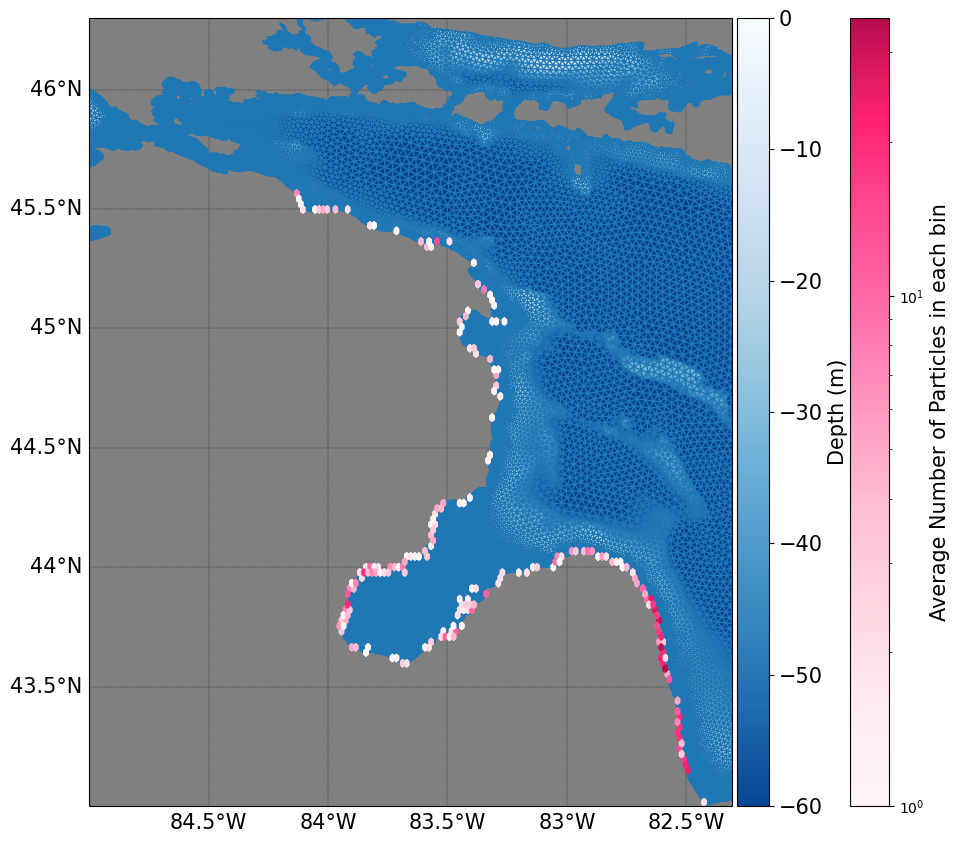

In [12]:
# Custom colormap setup (pink and blue shades)
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]

pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue_reversed', blue_shades_reversed)

# Initialize variables for storing hexbin data
all_bin_counts = []
all_coords = []

# Assuming 'first_intersections' contains the first intersections of particles with CW_avg
# Extract coordinates from 'first_intersections'
all_coords.extend(zip(first_intersections['geometry'].x, first_intersections['geometry'].y))

# Set up plotting parameters
font_size = 15
cmap = colourmap('h_r')

# Create figure and axis
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Load bathymetry data from NetCDF
grid_metrics_file_name = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)
extents = np.array([275, 277.69, 43, 46.3], dtype=float)
ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap=blue_cmap_reversed, zorder=0)

# Overlay grid on the plot
plotter.draw_grid(ax, linewidth=1.0)

# Initialize the hexbin grid based on the particle positions
hb = ax.hexbin(*zip(*all_coords), gridsize=100, cmap=pink_cmap, norm=LogNorm())
hexbin_grid = hb.get_offsets()

# Initialize variables to store results across months
accumulated_bin_counts = np.zeros(len(hexbin_grid))
total_particles_intersecting_CW = 0
total_particles_tracked = 0
total_particles_list = []
points_within_CW_list = []

# Hexbin plot based on the first intersections data
hb = ax.hexbin(first_intersections['geometry'].x, first_intersections['geometry'].y, gridsize=100, cmap=pink_cmap, norm=LogNorm(), reduce_C_function=np.sum, zorder=40)
bin_counts = hb.get_array()

# Accumulate bin counts
for i, count in enumerate(bin_counts):
    accumulated_bin_counts[i] += count

# Count the total particles intersecting with CW for the first time
total_particles_intersecting_CW += first_intersections['group_number'].nunique()

# Track total particles for the first intersection
total_particles_tracked += first_intersections['group_number'].nunique()  # Assuming you're tracking based on 'group_id'

# Track total particles and those within CW
total_particles_list.append(first_intersections.shape[0])
points_within_CW_list.append(first_intersections.shape[0])

# Calculate the average bin counts over the months
average_bin_counts = accumulated_bin_counts / len(total_particles_list)

# Calculate the average number of particles entering the shoreline buffer
average_particles_entering_CW = total_particles_intersecting_CW / len(total_particles_list)

# Calculate the percentage of particles that intersect the CW for the first time
percentage_particles_remain_in_CW = (total_particles_intersecting_CW / total_particles_tracked) * 100

# Output calculated values
print(f'Average number of particles returning the Coastal Wetland: {average_particles_entering_CW}')
print(f'Percentage of particles from total trajectories that intersect the Coastal Wetland: {percentage_particles_remain_in_CW:.2f}%')

# Update the hexbin plot with the average bin counts
hb = ax.hexbin(*zip(*hexbin_grid), gridsize=100, C=average_bin_counts, cmap=pink_cmap, norm=LogNorm(), zorder=40)

# Print the average number of particles in each bin
print("Average number of particles in each bin:")
for i, count in enumerate(average_bin_counts):
    print(f"Bin {i}: {count:.2f} particles")

# Set the axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add a colorbar to represent the average number of particles per bin
cbar = fig.colorbar(hb, ax=ax, pad=0.09)
cbar.set_label('Average Number of Particles in each bin', fontsize=15)

# Adjust the plot layout for the colorbar
plt.subplots_adjust(right=1)

# Show the plot
plt.show()


# 5-Add NP load to the particles

#### You can look at DirectNutrientload Directory, ZonalStats code to see how we obtain Zonal Stats 

In [ ]:
# path to Nutrient load data
Direct_Nutrient_load = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/ZonalStats/StreamWatresheds_total_N_P.csv'
Direct_Nutrient = pd.read_csv(Direct_Nutrient_load)
# Ensure the CSV contains the necessary columns
if 'Group_id' not in Direct_Nutrient.columns or 'WetLoad_TN_kg2' not in Direct_Nutrient.columns or 'WetLoad_TP_kg2' not in Direct_Nutrient.columns:
    raise ValueError("CSV file is missing required columns: 'Group_id', 'WetLoad_TN_kg2', 'WetLoad_TP_kg2'")

# Rename 'Group_id' to 'group_id' in the CSV to match the NetCDF data
Direct_Nutrient.rename(columns={'Group_id': 'group_id'}, inplace=True)

In [ ]:
Direct_Nutrient

In [ ]:
# read intersection output
CW_avg_intersections = pd.read_csv('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/results/first_intersections.csv')
CW_avg_intersections

In [ ]:

# Step 1: Count occurrences of each group_id in the NetCDF file
group_id_counts = CW_avg_intersections['group_id'].value_counts().to_dict()

# Step2: Merge particle data with nutrient load data
merged_data = pd.merge(CW_avg_intersections, Direct_Nutrient, on='group_id', how='left')

## Step 3: For each group_id, divide the WetLoad_TN_kg2 and WetLoad_TP_kg2 values by the count of that group_id
merged_data['WetLoad_TN_kg2'] = merged_data.apply(
        lambda row: row['WetLoad_TN_kg2'] / group_id_counts[row['group_id']] if pd.notnull(row['WetLoad_TN_kg2']) else None,
        axis=1)

merged_data['WetLoad_TP_kg2'] = merged_data.apply(
        lambda row: row['WetLoad_TP_kg2'] / group_id_counts[row['group_id']] if pd.notnull(row['WetLoad_TP_kg2']) else None,
        axis=1)


In [ ]:
merged_data

# 6- Plot Nitrogen return to Coastal Wetlands

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import numpy as np
from pylag.processing.plot import FVCOMPlotter, create_figure
import cartopy.crs as ccrs
from netCDF4 import Dataset

# Define a list of pink shades for the colormap
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
# Create a custom colormap
pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)

# Collect all coordinates and WetLoad_TN_kg2 data for plotting
all_coords = np.array(list(zip(merged_data['longitude'], merged_data['latitude'])))
wetload_tn = merged_data['WetLoad_TN_kg2'].values

# Plot settings
font_size = 15
cmap = pink_cmap

# Create the figure and axis using the FVCOM plotter
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Load bathymetry data (assuming you have it in your dataset)
grid_metrics_file_name = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)
extents = np.array([275, 277.69, 43, 46.3], dtype=float)
ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap='Blues', zorder=0)

# Overlay the grid
plotter.draw_grid(ax, linewidth=1.0)

# Create a hexbin plot where bins reflect WetLoad_TN_kg2 concentration
hb = ax.hexbin(all_coords[:, 0], all_coords[:, 1], C=wetload_tn, gridsize=80, cmap=cmap, norm=LogNorm(), reduce_C_function=np.sum, zorder=40)

# Add color bar for WetLoad_TN_kg2 concentration
cbar = fig.colorbar(hb, ax=ax, pad=0.1)
cbar.set_label('Annual Indirect Nitrogen load kg^2 per area', fontsize=15)

# Add axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Indirect Annual Nitrogen Load to coastal Wetlands with Average Inundation(kg^2/area)', fontsize=10)
# save the plot
plt.savefig('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/results/Indirect_Annual_Nitrogen_Load_to_Coastal_Wetlands_with_Average_Inundation.png', dpi=300)
# Show the plot
plt.show()


# 7-Plot Phosphorus return to coastal Wetlands 

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import numpy as np
from pylag.processing.plot import FVCOMPlotter, create_figure
import cartopy.crs as ccrs
from netCDF4 import Dataset

# Define a list of green shades for the colormap
green_shades =  ['#e0ffe0', '#b3ffb3', '#80ff80', '#4dff4d', '#00e600', '#00cc00', '#009900', '#006600', '#003300']
# Create a custom green colormap
green_cmap = LinearSegmentedColormap.from_list('custom_green', green_shades)

# Collect all coordinates and WetLoad_TP_kg2 data for plotting
all_coords = np.array(list(zip(merged_data['longitude'], merged_data['latitude'])))
wetload_tp = merged_data['WetLoad_TP_kg2'].values

# Plot settings
font_size = 15
cmap = green_cmap

# Create the figure and axis using the FVCOM plotter
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Load bathymetry data (assuming you have it in your dataset)
grid_metrics_file_name = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)
extents = np.array([275, 277.69, 43, 46.3], dtype=float)
ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap='Blues', zorder=0)

# Overlay the grid
plotter.draw_grid(ax, linewidth=1.0)

# Create a hexbin plot where bins reflect WetLoad_TP_kg2 concentration
hb = ax.hexbin(all_coords[:, 0], all_coords[:, 1], C=wetload_tp, gridsize=80, cmap=cmap, norm=LogNorm(), reduce_C_function=np.sum, zorder=40)

# Add color bar for WetLoad_TP_kg2 concentration
cbar = fig.colorbar(hb, ax=ax, pad=0.1)
cbar.set_label('Indirect Phosphorus load (kg^2 per area)', fontsize=15)

# Add axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Indirect Annual Phosphorus Load to coastal Wetlands with Average Inundation(kg^2/area)', fontsize=10, pad=20)


plt.savefig('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/results/Indirect_Annual_Phosphorus_Load_to_Coastal_Wetlands_with_Average_Inundation.png', dpi=300)
# Show the plot
plt.show()

In [ ]:
# Plot CW_avg
#Define a list of purple shades
import matplotlib.colors as colors


purple_shades = ['purple', 'violet', 'plum', 'thistle', 'mediumslateblue', 'darkorchid', 'mediumpurple', 'slateblue']
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
#blue_shades= ['royalblue','slateblue', 'mediumslateblue','mediumslateblue', 'mediumpurple','mediumorchid','plum']
# Create a custom purple colormap
purple_cmap = LinearSegmentedColormap.from_list('custom_purple', purple_shades)
#Create the figure and axis with FVCOM plotter
fig, ax = create_figure( figure_size=(26.,26.),projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Load bathymetry data
grid_metrics_file_name = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()
# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)

# Plot bathymetry
#extents = np.array([-84.10,-84.20, 45.58,45.65], dtype=float)
#extensts = np.array([-84,-81.3, 43,46], dtype=float)
#Lake Huron Ausable Point
extents = np.array([275, 277.69, 43, 46.3], dtype=float)
ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                              vmin=-60., vmax=0., cmap=blue_cmap_reversed, zorder = 0)

# Overlay grid
plotter.draw_grid(ax, linewidth=1.0)


# Plot the coastal wetland data with hexbin
hb = ax.hexbin(CW_avg['start_lon'], CW_avg['start_lat'], gridsize=100, cmap=purple_cmap, norm=LogNorm(), zorder=40)

# Add a colorbar
cbar = fig.colorbar(hb, ax=ax, pad=0.09)
cbar.set_label('Coastal Wetland Density avgerage inundation',fontsize=15)

# Adjust layout to make space for colorbar
plt.subplots_adjust(right=1)

# Add legend
plt.legend()
ax.set_title('Coastal Wetland Density with Average Inundation', fontsize=15,pad=20)
# Show the plot
plt.savefig('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/results/Coastal_Wetland_Density_avgInun.png', dpi=300)
plt.show()
